#### Required Libraries

In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import numpy as np
# import torchvision
# from torchvision import models, transforms
# import matplotlib
# import matplotlib.pyplot as plt
# import time
# import os
# import copy
# import random
# from datetime import datetime
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm

# from data_helper import UnlabeledDataset, LabeledDataset
# from helper import collate_fn, draw_box, compute_ts_road_map
# from modelzoo import *

In [2]:
import sys
sys.path.append("/scratch/mz2476/DL/project/")

from modelzoo import encoder

from ssl_project.ssl_ideas.model import ShuffleAndLearnModel
from ssl_project.utils import to_np
import numpy as np

import pytorch_lightning as pl 
from argparse import Namespace

from torch.utils.data import DataLoader

from pl_modules import VariationalAutoEncoder, AutoEncoder, MMDVariationalAutoEncoder
from argparse import Namespace
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from ssl_project.paths import *

In [3]:
###
## Example
###

# new_model = ShuffleAndLearnModel.load_from_checkpoint(
#     checkpoint_path="../ssl_ideas/lightning_logs/first_try_many_encoders=False/version_03/checkpoints/epoch=1.ckpt")
# encoder = new_model.model.resnet_encoder
# torch.save(encoder, "../pretrained_models/one_for_all_encoder_18.pth")


In [10]:
from importlib import reload
import pl_modules
reload(pl_modules)

<module 'pl_modules' from '/scratch/mz2476/DL/project/ssl_project/vehicle_layout_prediction/pl_modules.py'>

In [11]:
hparams =  Namespace(
   **{"resnet_style": "18",
      "pretrained": False,
      "path_to_pretrained_model" : f"{PATH_TO_REPO}/pretrained_models/one_for_all_encoder_18.pth",
      "threshold": 0.5,
      "n_scn_train": 24,
      "n_scn_val": 3, 
      "n_scn_test": 1,
      "batch_size": 8,
      "learning_rate": 0.0001,
      "weight_decay": 0.00001,
      "is_frozen": True,
      "lr_encoder_multiplier" : 1e-2,
     }
)

experiment_name = f"vae_final_is_frozen_{hparams.is_frozen}_lr_encoder_multiplier_{hparams.lr_encoder_multiplier}"

checkpoint_callback = ModelCheckpoint(
                    filepath="./checkpoints/" + experiment_name + "/checkpoint_{epoch}_{val_ts:.3f}",
                    save_top_k=3,
                    verbose=False,
                    monitor='val_ts',
                    mode='max',
                    prefix=''
                )

print(f"Experiment: {experiment_name}")
print("Parameters...")
print(hparams)

logger = pl.loggers.TensorBoardLogger("tb_logs", experiment_name)
logger.log_hyperparams(hparams)
model = pl_modules.VariationalAutoEncoderPretrainedHead(hparams)

Experiment: vae_final_is_frozen_True_lr_encoder_multiplier_0.01
Parameters...
Namespace(batch_size=8, is_frozen=True, learning_rate=0.0001, lr_encoder_multiplier=0.01, n_scn_test=1, n_scn_train=24, n_scn_val=3, path_to_pretrained_model='/scratch/mz2476/DL/project/ssl_project/pretrained_models/one_for_all_encoder_18.pth', pretrained=False, resnet_style='18', threshold=0.5, weight_decay=1e-05)
KEK


In [ ]:
# model.model.encoder.requires_grad_(False)

In [35]:
# for name, param in model.named_parameters():
#     print(f"{name:60} {param.requires_grad}")

In [ ]:
trainer = pl.Trainer(logger=logger, gpus=1, max_epochs=50, 
                     checkpoint_callback=checkpoint_callback)

trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:Set SLURM handle signals.
INFO:lightning:
   | Name                                          | Type                 | Params
-----------------------------------------------------------------------------------
0  | model                                         | vae                  | 48 M  
1  | model.encoder                                 | encoder              | 11 M  
2  | model.encoder.resnet_encoder                  | Sequential           | 11 M  
3  | model.encoder.resnet_encoder.0                | Conv2d               | 9 K   
4  | model.encoder.resnet_encoder.1                | BatchNorm2d          | 128   
5  | model.encoder.resnet_encoder.2                | ReLU                 | 0     
6  | model.encoder.resnet_encoder.3                | MaxPool2d            | 0     
7  | model.encoder.resnet_encoder.4                | Sequential           | 147 K 
8  | model.encoder.resne

# Segm to bb

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ssl_project.utils import compute_ats_bounding_boxes, get_bounding_boxes_from_seg

In [35]:
segmentation = np.zeros((800, 800))

segmentation[300:330, 90:160] = 1
segmentation[290:320, 190:260] = 1

pred_map = torch.Tensor(segmentation)
threshold = 0.5

bb_pred = get_bounding_boxes_from_seg(pred_map > threshold, 10, 800, 800)

In [37]:
bb_pred

tensor([[[-23.9000, -23.9000, -31.1000, -31.1000],
         [ 10.1000,   6.9000,  10.1000,   6.9000]],

        [[-24.0000, -24.0000, -31.0000, -31.0000],
         [ 10.0000,   7.0000,  10.0000,   7.0000]],

        [[-13.9000, -13.9000, -21.1000, -21.1000],
         [ 11.1000,   7.9000,  11.1000,   7.9000]],

        [[-14.0000, -14.0000, -21.0000, -21.0000],
         [ 11.0000,   8.0000,  11.0000,   8.0000]]])

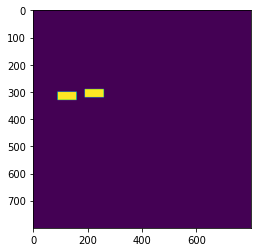

In [36]:
plt.imshow(segmentation)

In [ ]:
bb_pred = get_bounding_boxes_from_seg(pred_map > self.threshold, 10, 800, 800)
            ts_road_map = compute_ats_bounding_boxes(bb_pred.cpu(), target["bounding_box"].cpu())
            threat_score += ts_road_map